###### CSCE 320 :: Principles of Data Science ::Texas A&M University :: Fall 2020


# Group Project: Analysis of Election Data over Time for the purpose of finding the Optimal set of Training Data



Members: Matthew Spence, Adrian Shi, Marcel Theo, Michael Chaco

## Major Question:
What chronological subset of training data produces the most accurate election forecasting models?

## Purpose:
The outcomes of presidential elections shape U.S. government policy, which affects the lives of every American. We hope to determine if a predictive model generated from U.S. polling data is more or less accurate than historical data. 
Potential beneficiaries of this project are U.S. allies or businesses looking to predict the types of policies that will be implemented (which can affect their business)

## Method:
We intend to train two machine learning models of the same type on two different sets of training data. One will be trained on data going back as far as is available, and the other will be trained only on recent data. We will then compare the predictions of the two models to the actual outcome of the 2020 election, and see which is more accurate. 
 
### Getting started: 
First we need to gather our data and clean it. Our datasets are as follows: 
Popular Vote in U.S. Elections (Statista)
Historical Electoral Vote (Data Galore)
Historic head to head polling data (Gallup)
Incumbent approval ratings (Gallup)
Past electoral votes by state (Electoral-Vote.com)
Government Approval Ratings (Pew Research)
Unemployment rate (Trading Economics)
GDP growth by year (Trading Economics)


In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

# insert imports and data cleaning here
elections = pd.read_csv("CSV/elections-1900-to-2012.csv", encoding="utf-8") 
electoralVotes = pd.read_csv("CSV/electoral_votes.csv", encoding="utf-8") 
approvalRatings = pd.read_csv("CSV/incumbency_approval_ratings.csv", encoding="utf-8") 
#polling = pd.read_csv("CSV/polling.csv", encoding="utf-8") 
popularVotes = pd.read_csv("CSV/popular_votes.csv", encoding="utf-8") 
trustRating = pd.read_csv("CSV/trust_rating.csv", encoding="utf-8")

CleanedData = pd.read_csv("CSV/cleaned_data.csv", encoding="utf-8")


### A key decision in this project will be what machine learning model we use. We intend to use a model from the sklearn library. The goal of this project is not to test the accuracy of a given model per se, but rather to find the best set of training data. As such we considered a few relatively simple models:
Linear Regression<br>
Ridge Regression<br>
Lasso Regression<br>

### After reviewing the current techniques used in professional election forecasting, we decided that a linear regression would serve our purposes well. This model is already familiar to us through our class work, and is easy to work with. This will enable us to spend less time worrying about optimizing our model and more time testing different subsets of data. 



In [2]:
# get the data into a dataframe
data = pd.DataFrame(CleanedData)
data.head()

,year,electoral_d,electoral_r,total_electoral,electoral_d_percent,electoral_r_percent,popular_d,popular_r,popular_d_percent,popular_r_percent,poll_d,poll_r,incumbent,incumbent_won,incumbent_approval,trust,gdp_percent,party_won
0,1900,155,292,447,34.68%,65.32%,6370932,7228864,45.50%,51.70%,NaN,NaN,0,0,NaN,NaN,NaN,1
1,1904,140,336,476,29.41%,70.59%,5083880,7228864,37.60%,56.40%,NaN,NaN,1,1,NaN,NaN,NaN,1
2,1908,162,321,483,33.54%,66.46%,6408979,7678335,43%,51.60%,NaN,NaN,0,-1,NaN,NaN,NaN,1
3,1912,435,8,531,81.92%,1.51%,6296284,3486242,41.80%,23.20%,NaN,NaN,1,0,NaN,NaN,NaN,0
4,1916,277,254,531,52.17%,47.83%,9126868,8548728,52.16%,47.83%,NaN,NaN,1,1,NaN,NaN,NaN,0


### Once we have all of our raw data in an easily usable format, we need to divide the data into testable subsets. We want to see what chronologically continuous subset of training data provides the most accurate predictions for the 2020 election. That is, we want to train a model for every possible subset of data that includes every election after a given cutoff year, where the cutoff year will be set at some past election eg 1960-2016, 1964-2016, 1968-2016 ... 2012-2016, only 2016. This means that for n elections for which we have viable data, we will have n different subsets of data to test. 

In [37]:
# dataInRange returns the cleaned data in a given range of years.

def dataInRange(df, startYear, endYear):
    newDf = df[df['year'].between(startYear, endYear)]
    return newDf

### Before we train our models, we need the best available data on the 2020 election to get the various model's predictions.  

In [5]:
# import 2020 data

### Now that we have our training data and our model, we need to decide what technique to use to train the model. We also need to decide what metrics to attempt to predict to measure the accuracy of the models. We start by simply predicting the binary outcome, and naively training the model on the test data. 

In [3]:
# train the models to predict the binary outcome.
from sklearn.linear_model import LinearRegression

FIRST_YEAR = 1900
LAST_YEAR = 2016

predictions = []
    
# Iterate over every possible range of years
for i in range(LAST_YEAR,LAST_YEAR, 4): 
    for j in range(i, LAST_YEAR, 4):
        # train model for each of these subsets..
        subset = dataInRange(data, i, j)
        x = subset[''] # data from this subset of years
        y = subset['party_won'] # binary outcome data from this subset of years
        model = LinearRegression()
        model.fit(x,y)
        
        ### Next, predict y from the 2020 data
        #x_new = 2020 data x
        #y_new = model.predict(x_new[:, np.newaxis])
        #predictions.append(y_new)
        ### plot the results here?
        #plt.figure(figsize=(4, 3))
        #ax = plt.axes()
        #ax.scatter(x, y)
        #ax.plot(x_new, y_new)
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.axis('tight')
        #plt.show()
        
    

### We should now have our predictions, time to visualize the results

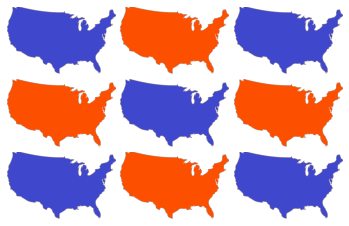

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import PIL

predictions = [1,0,1,0,1,0,1,0,1]
images = []
redMap = PIL.Image.open('Images/RedMap.png')
blueMap= PIL.Image.open('Images/BlueMap.png')

for res in predictions:
    images.append(blueMap.copy() if res==1 else redMap.copy())

def display_grid(imgs, grid_shape, scale=0.1, axes_pad=0.07):

    # Grid must be 2D:
    assert len(grid_shape) == 2

    # Make sure all images can fit in grid:
    assert grid_shape[0]*grid_shape[1] >= len(imgs)

    grid = ImageGrid(plt.gcf(), 111, grid_shape, axes_pad=axes_pad)
    for i, data in enumerate(imgs):

        # Scale image:
        im = data
        thumb_shape = [im.size[0]*scale, im.size[1]*scale]
        im.thumbnail(thumb_shape, PIL.Image.ANTIALIAS)
        data_thumb = np.array(im)
        grid[i].imshow(data_thumb)

        # Turn off axes:
        grid[i].axes.get_xaxis().set_visible(False)
        grid[i].axes.get_yaxis().set_visible(False)
        grid[i].axis("off")

display_grid(images, [3, 3], scale=0.5)


### This gets us our predictions, but we have a problem. (Most/All/A lot) of the models predict the same result.The binary outcome is simply not enough to guage which model is most accurate. As such, we decided to predict the popular vote instead. This will allow for more granular comparisons, since popular votes are much more variable than binary election outcomes.  

In [ ]:
# use the same techniques as before the predict the popular vote margin

### Now that the 2020 election is over, we can compare the predictions of our models to the actual results. 

## Results: 